## 1 Anomaly Detection ##


### Introduction ###
Anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

In [239]:
import scipy.io
import numpy as np
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from scipy.stats import norm
from platform import python_version
print(python_version())

3.8.5


In [240]:
data = scipy.io.loadmat('ex8data1.mat')
type(data)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [241]:
X = data['X']
X.shape

(307, 2)

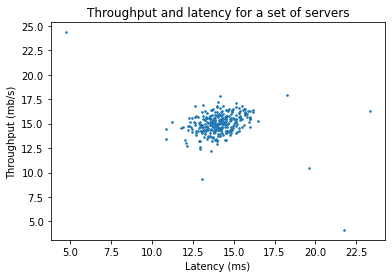

In [242]:
plt.scatter(X[:, 0], X[:, 1], marker='.', s=10)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Throughput and latency for a set of servers')
plt.show()

### 1.1 Gaussian distribution ###

For this exercise, we assume a Gaussian distribution for the dataset.

We first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the 
points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

In [243]:
def estimateGaussian(X):
    
    m, n = X.shape
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    
    return mu, sigma2

In [244]:
mu, sigma2 = estimateGaussian(X)

In [245]:
#p1 = norm.cdf(X, mu, sigma2)
#p = scipy.stats.multivariate_normal(mu, sigma2).pdf(X)

In [246]:
def multivariateGaussian(X, mu, sigma2):
    k = mu.size
    if sigma2.ndim == 1:
            sigma2 = np.diag(sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(sigma2) ** (-0.5)\
         * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma2)) * X, axis=1))
    return p

In [247]:
p = multivariateGaussian(X, mu, sigma2)

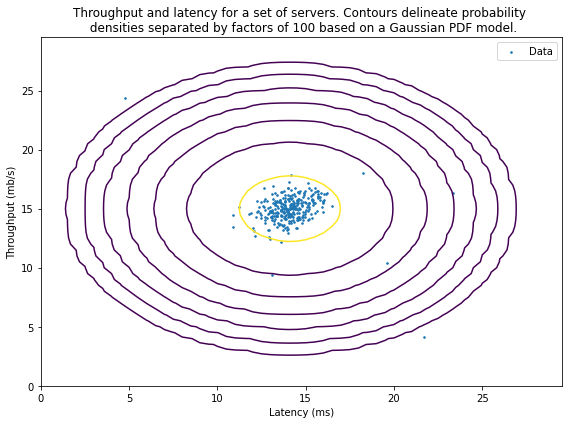

In [248]:
#def visualizeFit(X, mu, sigma2):
X1, X2 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
Z = Z.reshape(X1.shape)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], marker='.', s=10,label='Data')
plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Throughput and latency for a set of servers.'
          ' Contours delineate probability \n densities separated'
          ' by factors of 100 based on a Gaussian PDF model.')
plt.tight_layout()
plt.legend()
plt.show()
    

### 1.3 Selecting the threshold, ε ###

In [249]:
Xval = data['Xval']
yval = data ['yval']

In [250]:
pval = multivariateGaussian(Xval, mu, sigma2);
pval.shape

(307,)

In [251]:
print(yval.shape)
yval = yval.flatten() ##shape of pval and yval should be same
yval.shape

(307, 1)


(307,)

In [252]:
#SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
#outliers
#   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
#   threshold to use for selecting outliers based on the results from a
#   validation set (pval) and the ground truth (yval).

def selectThreshold(yval, pval):
    
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    
    stepsize = (np.max(pval) -  np.min(pval))/1000
    
    for epsilon in np.arange(np.min(pval), np.max(pval), stepsize):
        
        cvPredictions = (pval < epsilon)
        tp = np.sum((cvPredictions == 1) & (yval == 1))
        fp = np.sum((cvPredictions == 1) & (yval == 0))
        fn = np.sum((cvPredictions == 0) & (yval == 1))
        
        #print("tp", tp)
        #print("fp", fp)
        #suppress/hide division by zero warning
        np.seterr(invalid='ignore')
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            
    return bestEpsilon, bestF1

In [253]:
epsilon, F1 = selectThreshold(yval, pval)

In [254]:
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('you should see a value epsilon of about 8.99e-05')
print('you should see a Best F1 value of  0.875000')

Best epsilon found using cross-validation: 8.99e-05
Best F1 on Cross Validation Set:  0.875000
you should see a value epsilon of about 8.99e-05
you should see a Best F1 value of  0.875000


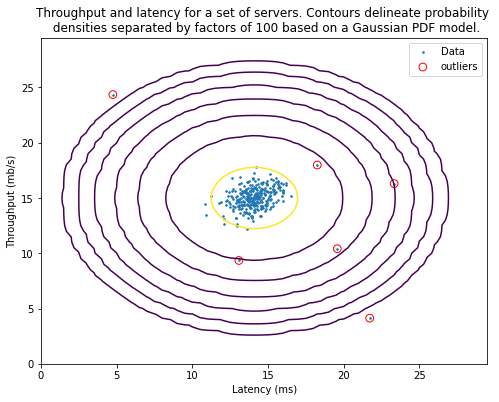

In [255]:
#find outliers and plot them.
outliers = p < epsilon

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], marker='.', s=10,label='Data')
#https://stackoverflow.com/questions/4143502/how-to-do-a-scatter-plot-with-empty-circles-in-python
plt.scatter(X[outliers, 0], X[outliers, 1], s=60, facecolors='none', edgecolors='r',label='outliers')

plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Throughput and latency for a set of servers.'
          ' Contours delineate probability \n densities separated'
          ' by factors of 100 based on a Gaussian PDF model.')
plt.legend()
plt.show()





### 1.4 High dimensional dataset ###

In this dataset, each example is described by 11 features, capturing many more
properties of your compute servers.

In [256]:
data = scipy.io.loadmat('ex8data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [257]:
X = data['X']
Xval = data['Xval']
yval = data['yval']
yval = yval.flatten()
X.shape

(1000, 11)

In [260]:
# Estimate Guassian parameters mu and sigma
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)

pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
outliers = sum(p < epsilon)

print('Best epsilon found using cross-validation:', epsilon)
print(' you should see a value epsilon of about 1.38e-18')
print('Best F1 on Cross Validation Set:', F1)
print('you should see a Best F1 value of 0.615385)')
print('Outliers found:', Outliers)
print('you should find 117 anomalies')

Best epsilon found using cross-validation: 1.377228890761358e-18
 you should see a value epsilon of about 1.38e-18
Best F1 on Cross Validation Set: 0.6153846153846154
you should see a Best F1 value of 0.615385)
Outliers found: 117
you should find 117 anomalies
